# Surf park de Canéjan : simulation de l'approvisionement des bassins en eau

### Objectifs

Ce document vise à établir les fondations du modèle d'approvisionement en eaux des bassis du surf park de Canéjan.

### Hypothèses

- Les deux bassins sont communicant, sans limite de flux.

## Imports

In [1]:

import os
import pandas as pd
import networkx as nx
import numpy as np

from plotnine import *

from pywr.model import Model
from pywr.notebook import draw_graph
from pyet.combination import penman

from naseb.model import model_pet_visual_crossing

## Collection de données

In [2]:
meteo_journaliere = pd.read_csv(
        './data/canéjan interpolé 1992-01-01 to 2022-12-31.csv')
meteo_decadaire = pd.read_csv('./data/weather.csv')

## Vérification des données journalières

L'objectif de cet section est de vérifier:
- la cohérence des données journalières de précipitation avec les données decadaires (10j)
- valider le modèle d'évapotranspiration potentielle

In [3]:
meteo_journaliere = model_pet_visual_crossing(meteo_journaliere)
meteo_journaliere.columns

                  datetime       tempmax       tempmin          temp  \
count                11323  11323.000000  11323.000000  11323.000000   
mean   2007-07-02 00:00:00     18.667208      9.599717     13.933383   
min    1992-01-01 00:00:00     -3.200000     -8.900000     -5.700000   
25%    1999-10-01 12:00:00     13.100000      5.500000      9.500000   
50%    2007-07-02 00:00:00     18.200000      9.900000     13.800000   
75%    2015-04-01 12:00:00     24.000000     14.100000     18.800000   
max    2022-12-31 00:00:00     40.300000     24.900000     31.700000   
std                    NaN      7.221889      5.793402      6.247120   

       feelslikemax  feelslikemin     feelslike           dew      humidity  \
count  11322.000000  11322.000000  11322.000000  11322.000000  11323.000000   
mean      18.466216      8.591388     13.380595      9.244285     76.309732   
min       -7.800000    -14.400000    -10.900000    -12.600000     30.200000   
25%       13.100000      3.500000  

Index(['name', 'datetime', 'tempmax', 'tempmin', 'temp', 'feelslikemax',
       'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob',
       'precipcover', 'preciptype', 'snow', 'snowdepth', 'windgust',
       'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility',
       'solarradiation', 'solarenergy', 'uvindex', 'severerisk', 'sunrise',
       'sunset', 'moonphase', 'conditions', 'description', 'icon', 'stations',
       'hours_of_daylight', 'dayofyear', 'pet_penman', 'pet_kimberly_penman'],
      dtype='object')

In [10]:
meteo_journaliere['hours_of_daylight'].describe()

count    11323.000000
mean        12.225134
std          2.328361
min          8.791944
25%          9.975833
50%         12.254722
75%         14.480694
max         15.586111
Name: hours_of_daylight, dtype: float64

In [4]:
def decade(day):
    if day <11:
        return 1
    elif day <21:
        return 2
    else:
        return 3

meteo_journaliere['dayofmonth'] = meteo_journaliere["datetime"].dt.day
meteo_journaliere['month'] = meteo_journaliere["datetime"].dt.month
meteo_journaliere['year'] = meteo_journaliere["datetime"].dt.year
meteo_journaliere['decade'] = meteo_journaliere["dayofmonth"].apply(decade)
meteo_j_agg_decadaire = meteo_journaliere.groupby(['month', 'decade', 'year'])[['precip', 'pet_penman', 'pet_kimberly_penman']].sum()
meteo_j_agg_decadaire

precip  pet_penman  pet_kimberly_penman
month decade year                                         
1     1      1992  24.621   16.985052            16.985052
             1993   0.021   15.203445            15.203445
             1994  47.322   18.659707            18.659707
             1995  36.619   14.880599            14.880599
             1996  13.413   19.237939            19.237939
...                   ...         ...                  ...
12    3      2018  15.920   14.419611            14.419611
             2019  21.551   22.601090            22.601090
             2020  73.197   17.447125            17.447125
             2021  37.718   18.668151            18.668151
             2022  33.905   22.110689            22.110689

[1116 rows x 3 columns]

In [5]:
meteo_decadaire['DATE'] = pd.to_datetime(meteo_decadaire['DATE'])

meteo_decadaire['dayofmonth'] = meteo_decadaire["DATE"].dt.day
meteo_decadaire['month'] = meteo_decadaire["DATE"].dt.month
meteo_decadaire['year'] = meteo_decadaire["DATE"].dt.year

In [6]:
meteo_decadaire_merged = meteo_decadaire.merge(meteo_j_agg_decadaire, right_index=True, left_on=['month', 'DECADE','year'])
meteo_decadaire_merged

,DATE,DECADE,RR,FFM,ETP,dayofmonth,month,year,precip,pet_penman,pet_kimberly_penman
0,1992-01-01,1,24.2,3.4,4.2,1,1,1992,24.621,16.985052,16.985052
1,1992-01-11,2,0.0,2.2,2.3,11,1,1992,0.028,13.053491,13.053491
2,1992-01-21,3,1.0,2.8,6.3,21,1,1992,1.020,20.240601,20.240601
3,1992-02-01,1,1.8,2.1,6.6,1,2,1992,2.147,21.321423,21.321423
4,1992-02-11,2,14.2,3.4,13.2,11,2,1992,16.000,35.317386,35.317386
...,...,...,...,...,...,...,...,...,...,...,...
1111,2022-11-11,2,52.9,3.2,7.3,11,11,2022,45.982,23.767519,23.767519
1112,2022-11-21,3,74.7,3.2,6.4,21,11,2022,74.143,16.384041,16.384041
1113,2022-12-01,1,3.8,2.8,4.5,1,12,2022,2.388,15.183984,15.183984
1114,2022-12-11,2,18.7,3.6,4.1,11,12,2022,18.336,15.860242,15.860242


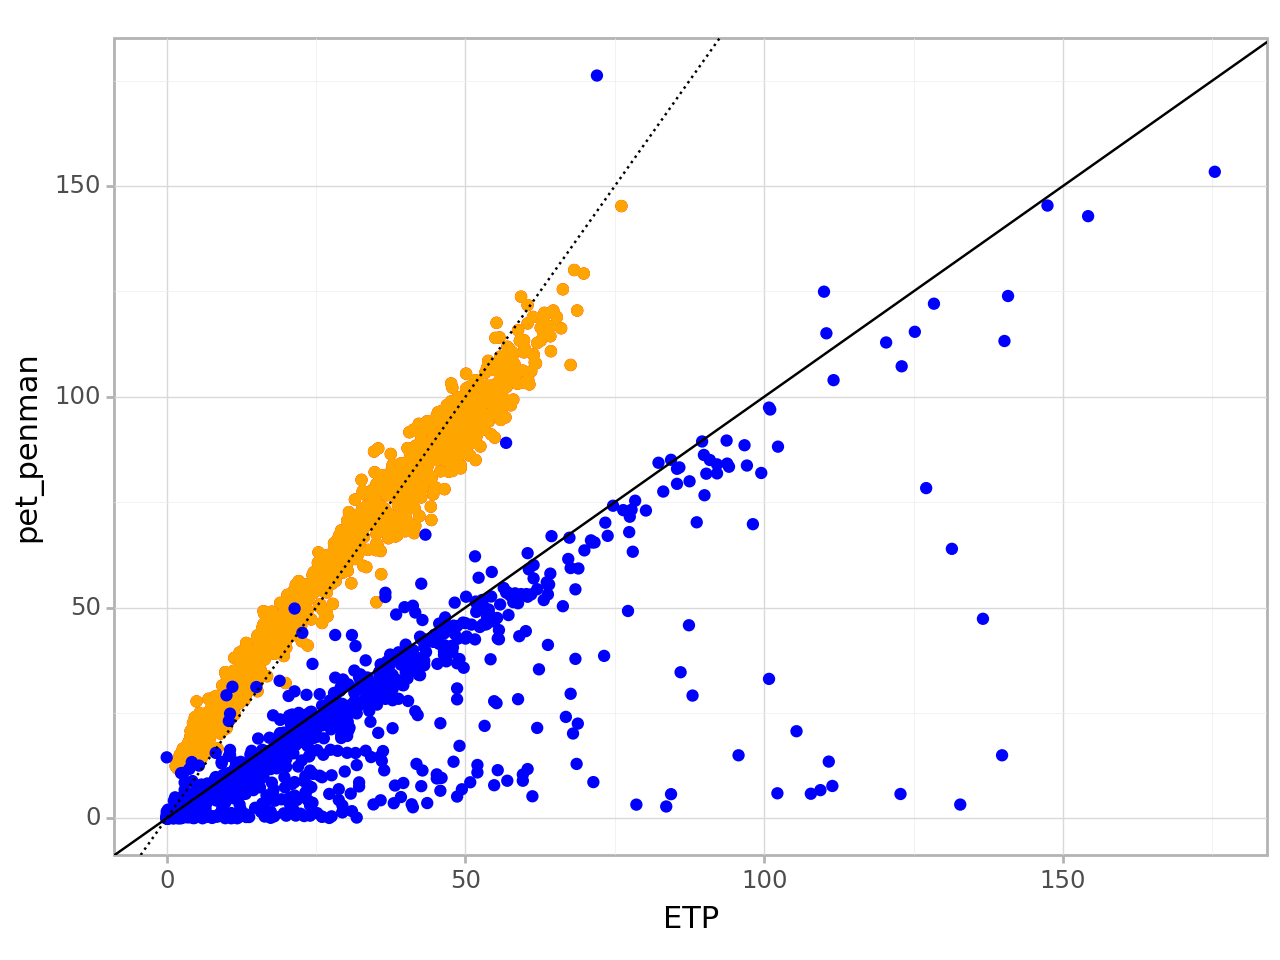

<Figure Size: (640 x 480)>

In [7]:
(
    ggplot(meteo_decadaire_merged)
    + geom_point(aes("ETP", 'pet_penman'), colour="red")
    + geom_point(aes("ETP", 'pet_kimberly_penman'), colour="orange")
    + geom_point(aes("RR", 'precip'), colour="blue")
    + geom_abline()
    + geom_abline(slope=2, linetype="dotted")
    + theme_light()
)